# Clasificaci√≥n de Tumores Mamarios con SVM - CBIS-DDSM

Este notebook utiliza los archivos de entrada (`train_split.parquet`, `val_split.parquet`, `test_split.parquet`), para implementar un modelo **SVM (M√°quinas de Vectores de Soporte)**

In [2]:
# Librer√≠as necesarias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
!pip install pyarrow

#### verificando que features existen en los archivos: test_features.parquet, val_features.parquet, train_features.parquet

In [4]:
import pandas as pd

# Definir la ruta base
ruta_base = "/Users/clubability/Documents/SVM con 7 features/dataset clean"

# Cargar los archivos
train_features = pd.read_parquet(f"{ruta_base}/train_features.parquet")
val_features = pd.read_parquet(f"{ruta_base}/val_features.parquet")
test_features = pd.read_parquet(f"{ruta_base}/test_features.parquet")

# Mostrar las cabeceras
print("Train features:")
display(train_features.head())

print("\n Validation features:")
display(val_features.head())

print("\n Test features:")
display(test_features.head())

# Mostrar columnas disponibles
print("\n Columnas en train_features:")
print(train_features.columns.tolist())


Train features:


image_path  \
0  Mass-Test_P_01395_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
1  Mass-Test_P_01110_RIGHT_CC/1.3.6.1.4.1.9590.10...   
2  Mass-Training_P_00401_LEFT_MLO/1.3.6.1.4.1.959...   
3  Calc-Test_P_01845_RIGHT_CC/1.3.6.1.4.1.9590.10...   
4  Mass-Training_P_01557_RIGHT_CC/1.3.6.1.4.1.959...   

                                        cropped_path  \
0  Mass-Test_P_01395_RIGHT_MLO_1/1.3.6.1.4.1.9590...   
1  Mass-Test_P_01110_RIGHT_CC_1/1.3.6.1.4.1.9590....   
2  Mass-Training_P_00401_LEFT_MLO_1/1.3.6.1.4.1.9...   
3  Calc-Test_P_01845_RIGHT_CC_1/1.3.6.1.4.1.9590....   
4  Mass-Training_P_01557_RIGHT_CC_1/1.3.6.1.4.1.9...   

                                            roi_path abnormality type  \
0  Mass-Test_P_01395_RIGHT_MLO_1/1.3.6.1.4.1.9590...             mass   
1  Mass-Test_P_01110_RIGHT_CC_1/1.3.6.1.4.1.9590....             mass   
2  Mass-Training_P_00401_LEFT_MLO_1/1.3.6.1.4.1.9...             mass   
3  Calc-Test_P_01845_RIGHT_CC_1/1.3.6.1.4.1.9590....    calcification   
4  Mass-Training_P_01557_RIGHT_CC_1/1.3.6.1.4.1.9...             mass   

   assessment  breast_density calc distribution    calc type image view  \
0           3               1              None         None        MLO   
1           5               4              None         None         CC   
2           3               2              None         None        MLO   
3           4               2         CLUSTERED  PLEOMORPHIC         CC   
4           3               4              None         None         CC   

  left or right breast  ...  pathology image_path_exists  cropped_path_exists  \
0                RIGHT  ...     BENIGN             False                False   
1                RIGHT  ...  MALIGNANT             False                False   
2                 LEFT  ...     BENIGN             False                False   
3                RIGHT  ...     BENIGN             False                False   
4                RIGHT  ...     BENIGN             False                False   

  roi_path_exists                                    full_image_path  exists  \
0           False  D:\TFM_CBIS\images\CBIS-DDSM\Mass-Test_P_01395...    True   
1           False  D:\TFM_CBIS\images\CBIS-DDSM\Mass-Test_P_01110...    True   
2           False  D:\TFM_CBIS\images\CBIS-DDSM\Mass-Training_P_0...    True   
3           False  D:\TFM_CBIS\images\CBIS-DDSM\Calc-Test_P_01845...    True   
4           False  D:\TFM_CBIS\images\CBIS-DDSM\Mass-Training_P_0...    True   

   mean_intensity  std_intensity width  height  
0        0.276493       0.255702  2968    4712  
1        0.177803       0.250622  4051    6871  
2        0.225781       0.255833  3560    5792  
3        0.181317       0.239942  2506    4591  
4        0.243918       0.302651  2356    4531  

[5 rows x 24 columns]


 Validation features:


image_path  \
0  Calc-Training_P_01569_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00852_LEFT_CC/1.3.6.1.4.1.9590...   
2  Calc-Training_P_00425_RIGHT_MLO/1.3.6.1.4.1.95...   
3  Calc-Training_P_00471_LEFT_CC/1.3.6.1.4.1.9590...   
4  Calc-Training_P_00471_LEFT_CC/1.3.6.1.4.1.9590...   

                                        cropped_path  \
0  Calc-Training_P_01569_RIGHT_CC_2/1.3.6.1.4.1.9...   
1  Calc-Training_P_00852_LEFT_CC_1/1.3.6.1.4.1.95...   
2  Calc-Training_P_00425_RIGHT_MLO_1/1.3.6.1.4.1....   
3  Calc-Training_P_00471_LEFT_CC_2/1.3.6.1.4.1.95...   
4  Calc-Training_P_00471_LEFT_CC_2/1.3.6.1.4.1.95...   

                                            roi_path abnormality type  \
0  Calc-Training_P_01569_RIGHT_CC_2/1.3.6.1.4.1.9...    calcification   
1  Calc-Training_P_00852_LEFT_CC_1/1.3.6.1.4.1.95...    calcification   
2  Calc-Training_P_00425_RIGHT_MLO_1/1.3.6.1.4.1....    calcification   
3  Calc-Training_P_00471_LEFT_CC_2/1.3.6.1.4.1.95...    calcification   
4  Calc-Training_P_00471_LEFT_CC_2/1.3.6.1.4.1.95...    calcification   

   assessment  breast_density calc distribution           calc type  \
0           4               4         CLUSTERED  PUNCTATE-AMORPHOUS   
1           4               4         CLUSTERED         PLEOMORPHIC   
2           2               1         CLUSTERED  COARSE-PLEOMORPHIC   
3           2               3               N/A     VASCULAR-COARSE   
4           2               3               N/A     VASCULAR-COARSE   

  image view left or right breast  ...                pathology  \
0         CC                RIGHT  ...                   BENIGN   
1         CC                 LEFT  ...                MALIGNANT   
2        MLO                RIGHT  ...                   BENIGN   
3         CC                 LEFT  ...  BENIGN_WITHOUT_CALLBACK   
4         CC                 LEFT  ...  BENIGN_WITHOUT_CALLBACK   

  image_path_exists  cropped_path_exists roi_path_exists  \
0             False                False           False   
1             False                False           False   
2             False                False           False   
3             False                False           False   
4             False                False           False   

                                     full_image_path  exists  mean_intensity  \
0  D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...    True        0.100049   
1  D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...    True        0.250439   
2  D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...    True        0.136949   
3  D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...    True        0.304826   
4  D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...    True        0.304826   

   std_intensity width  height  
0       0.203093  3032    4648  
1       0.260817  3901    5596  
2       0.196653  3976    5728  
3       0.290419  3072    4688  
4       0.290419  3072    4688  

[5 rows x 24 columns]


 Test features:


image_path  \
0  Mass-Training_P_01142_RIGHT_MLO/1.3.6.1.4.1.95...   
1  Calc-Training_P_00220_LEFT_CC/1.3.6.1.4.1.9590...   
2  Calc-Training_P_01691_RIGHT_CC/1.3.6.1.4.1.959...   
3  Mass-Training_P_00146_RIGHT_MLO/1.3.6.1.4.1.95...   
4  Calc-Training_P_01321_RIGHT_MLO/1.3.6.1.4.1.95...   

                                        cropped_path  \
0  Mass-Training_P_01142_RIGHT_MLO_1/1.3.6.1.4.1....   
1  Calc-Training_P_00220_LEFT_CC_1/1.3.6.1.4.1.95...   
2  Calc-Training_P_01691_RIGHT_CC_3/1.3.6.1.4.1.9...   
3  Mass-Training_P_00146_RIGHT_MLO_1/1.3.6.1.4.1....   
4  Calc-Training_P_01321_RIGHT_MLO_3/1.3.6.1.4.1....   

                                            roi_path abnormality type  \
0  Mass-Training_P_01142_RIGHT_MLO_1/1.3.6.1.4.1....             mass   
1  Calc-Training_P_00220_LEFT_CC_1/1.3.6.1.4.1.95...    calcification   
2  Calc-Training_P_01691_RIGHT_CC_3/1.3.6.1.4.1.9...    calcification   
3  Mass-Training_P_00146_RIGHT_MLO_1/1.3.6.1.4.1....             mass   
4  Calc-Training_P_01321_RIGHT_MLO_3/1.3.6.1.4.1....    calcification   

   assessment  breast_density calc distribution  \
0           3               2              None   
1           4               3         CLUSTERED   
2           2               3               N/A   
3           5               1              None   
4           5               1  CLUSTERED-LINEAR   

                           calc type image view left or right breast  ...  \
0                               None        MLO                RIGHT  ...   
1                        PLEOMORPHIC         CC                 LEFT  ...   
2  ROUND_AND_REGULAR-LUCENT_CENTERED         CC                RIGHT  ...   
3                               None        MLO                RIGHT  ...   
4              FINE_LINEAR_BRANCHING        MLO                RIGHT  ...   

                 pathology image_path_exists  cropped_path_exists  \
0  BENIGN_WITHOUT_CALLBACK             False                False   
1                   BENIGN             False                False   
2  BENIGN_WITHOUT_CALLBACK             False                False   
3                MALIGNANT             False                False   
4                MALIGNANT             False                False   

  roi_path_exists                                    full_image_path  exists  \
0           False  D:\TFM_CBIS\images\CBIS-DDSM\Mass-Training_P_0...    True   
1           False  D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...    True   
2           False  D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...    True   
3           False  D:\TFM_CBIS\images\CBIS-DDSM\Mass-Training_P_0...    True   
4           False  D:\TFM_CBIS\images\CBIS-DDSM\Calc-Training_P_0...    True   

   mean_intensity  std_intensity width  height  
0        0.171137       0.219140  2896    4504  
1        0.181426       0.242956  3556    5821  
2        0.065731       0.159688  2912    4632  
3        0.145576       0.230362  3600    5904  
4        0.288693       0.303531  3112    4776  

[5 rows x 24 columns]


 Columnas en train_features:
['image_path', 'cropped_path', 'roi_path', 'abnormality type', 'assessment', 'breast_density', 'calc distribution', 'calc type', 'image view', 'left or right breast', 'mass margins', 'mass shape', 'subtlety', 'type', 'pathology', 'image_path_exists', 'cropped_path_exists', 'roi_path_exists', 'full_image_path', 'exists', 'mean_intensity', 'std_intensity', 'width', 'height']


### Celda para inspeccionar tipo de dato de cada feature

In [5]:
import pandas as pd

# Ruta local a tu dataset
ruta_base = "/Users/clubability/Documents/SVM con 7 features/dataset clean"

# Cargar archivo de entrenamiento
train_features = pd.read_parquet(f"{ruta_base}/train_features.parquet")

# Lista de los 7 features
features_usar = [
    "mean_intensity",
    "std_intensity",
    "width",
    "height",
    "assessment",
    "breast_density",
    "subtlety"
]

# Mostrar tipo de dato y valores √∫nicos por feature
for feature in features_usar:
    print(f"Feature: {feature}")
    print("Tipo de dato:", train_features[feature].dtype)
    print("Valores √∫nicos (primeros 10):", train_features[feature].unique()[:10])
    print("-" * 50)


Feature: mean_intensity
Tipo de dato: float32
Valores √∫nicos (primeros 10): [0.27649295 0.17780286 0.22578062 0.18131712 0.2439181  0.18151662
 0.156277   0.23517795 0.09983147 0.16313621]
--------------------------------------------------
Feature: std_intensity
Tipo de dato: float32
Valores √∫nicos (primeros 10): [0.25570193 0.25062153 0.25583294 0.23994246 0.30265105 0.22831237
 0.15634982 0.2666778  0.19026154 0.26763454]
--------------------------------------------------
Feature: width
Tipo de dato: int64
Valores √∫nicos (primeros 10): [2968 4051 3560 2506 2356 3728 3571 2896 2936 3056]
--------------------------------------------------
Feature: height
Tipo de dato: int64
Valores √∫nicos (primeros 10): [4712 6871 5792 4591 4531 5760 5056 5461 4544 4496]
--------------------------------------------------
Feature: assessment
Tipo de dato: int32
Valores √∫nicos (primeros 10): [3 5 4 2 0 1]
--------------------------------------------------
Feature: breast_density
Tipo de dato: int32


### Crear la variable objetivo `pathology_label`

#### En esta celda convertimos la columna `pathology` (que contiene etiquetas como "MALIGNANT", "BENIGN", etc.) en una versi√≥n num√©rica llamada `pathology_label`, que ser√° utilizada como variable objetivo (`y`) para entrenar el modelo SVM.


In [6]:
# Crear la columna num√©rica 'pathology_label' a partir de la etiqueta original
mapeo = {
    'BENIGN_WITHOUT_CALLBACK': 0,
    'BENIGN': 1,
    'MALIGNANT': 2
}

train_features['pathology_label'] = train_features['pathology'].map(mapeo)
val_features['pathology_label'] = val_features['pathology'].map(mapeo)
test_features['pathology_label'] = test_features['pathology'].map(mapeo)


### Filtrar solo los 7 features seleccionados y separar `X` e `y`

#### Aqu√≠ seleccionamos √∫nicamente las 7 variables predictoras (features) que queremos usar para entrenar el modelo. Luego separamos `X` (las features) e `y` (la etiqueta objetivo).


In [7]:
# Seleccionar los 7 features relevantes
features_usar = [
    "mean_intensity",
    "std_intensity",
    "width",
    "height",
    "assessment",
    "breast_density",
    "subtlety"
]

# Separar features (X) y variable objetivo (y)
X_train = train_features[features_usar].copy()
X_val = val_features[features_usar].copy()
X_test = test_features[features_usar].copy()

y_train = train_features["pathology_label"]
y_val = val_features["pathology_label"]
y_test = test_features["pathology_label"]


## An√°lisis Exploratorio de Datos (EDA)
#### Exploramos las correlaciones entre variables y la distribuci√≥n por clase.

### Matriz de correlaci√≥n entre los features y la clase `pathology_label`

Este gr√°fico muestra la matriz de correlaci√≥n de Pearson entre los 7 features seleccionados y la variable objetivo `pathology_label`, la cual representa la clase de la lesi√≥n codificada num√©ricamente (0 = BENIGN_WITHOUT_CALLBACK, 1 = BENIGN, 2 = MALIGNANT).

Este an√°lisis permite:

- Identificar relaciones lineales entre los features.
- Evaluar la fuerza de asociaci√≥n entre cada variable predictora y la clase.
- Detectar posibles redundancias entre variables (por alta correlaci√≥n entre ellas).

Cuanto mayor sea el valor absoluto de la correlaci√≥n con `pathology_label`, mayor potencial tendr√° el feature como predictor.


In [8]:
# Define la lista de tus 7 features como features_usar
features_usar = [
    "mean_intensity",
    "std_intensity",
    "width",
    "height",
    "assessment",
    "breast_density",
    "subtlety"
]

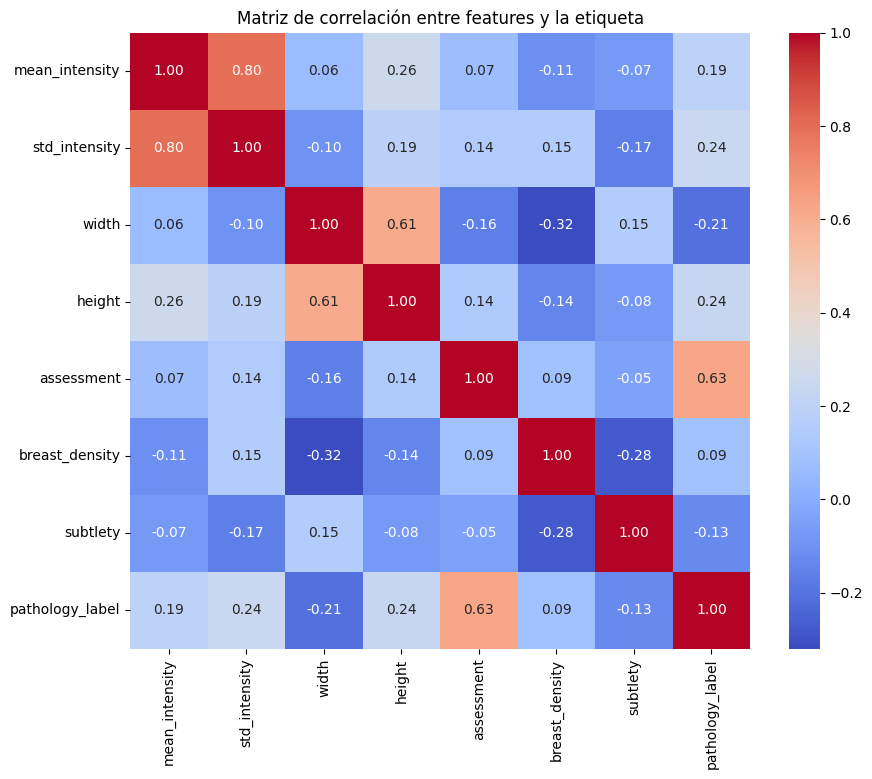

In [16]:
# Matriz de correlaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = train_features[features_usar + ['pathology_label']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlaci√≥n entre features y la etiqueta")
plt.show()

### An√°lisis de la distribuci√≥n de los features seg√∫n la clase `pathology_label`

En esta secci√≥n se utilizan boxplots para visualizar c√≥mo var√≠an los valores de cada feature (visual o cl√≠nico) en funci√≥n de la clase de la lesi√≥n (`pathology_label`).

Esto permite detectar:
- Diferencias en la distribuci√≥n por clase.
- Outliers o valores extremos.
- Features con potencial poder discriminativo para el modelo.

Cada gr√°fico compara la distribuci√≥n de un feature frente a las clases:
- `0 = BENIGN_WITHOUT_CALLBACK`
- `1 = BENIGN`
- `2 = MALIGNANT`

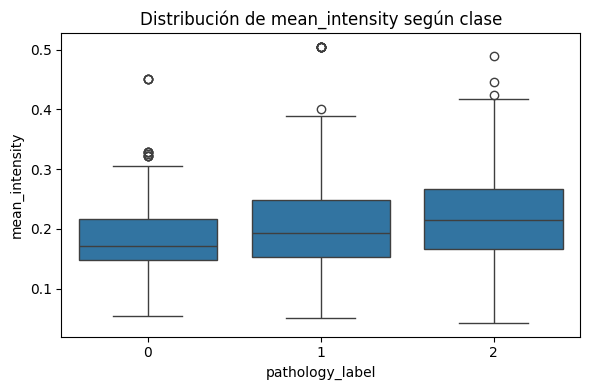

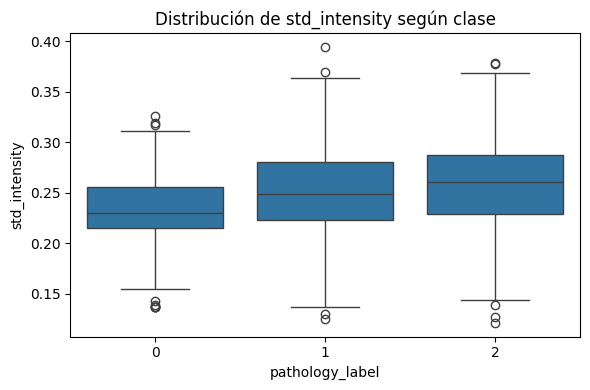

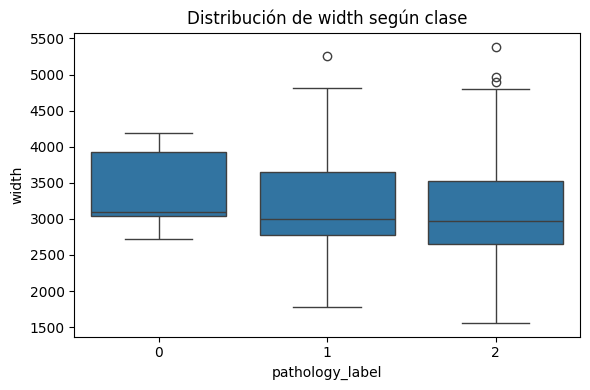

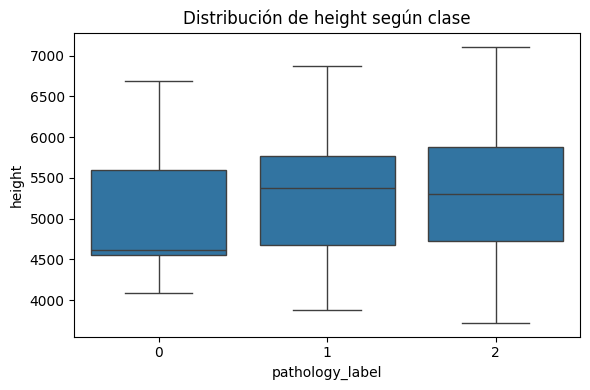

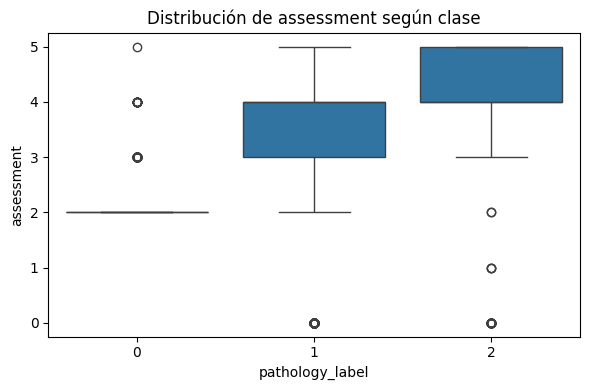

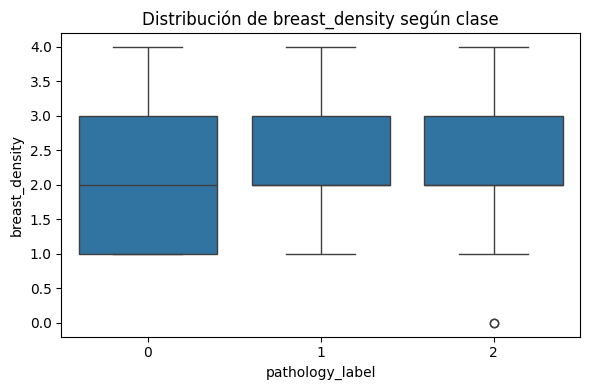

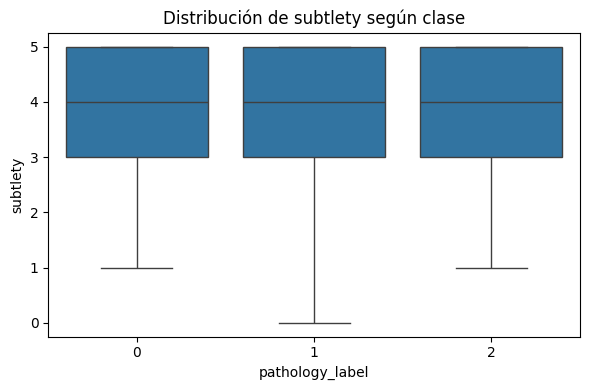

In [17]:
for col in features_usar:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='pathology_label', y=col, data=train_features)
    plt.title(f"Distribuci√≥n de {col} seg√∫n clase")
    plt.xlabel("pathology_label")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

### Visualizaci√≥n de im√°genes m√©dicas DICOM

Este bloque permite recorrer autom√°ticamente las primeras im√°genes del dataset CBIS-DDSM en formato DICOM.

Se muestran ejemplos de mamograf√≠as reales cargadas con `pydicom`, lo cual es √∫til para:

- Validar que las rutas est√©n bien construidas.
- Observar diferencias visuales entre clases.
- Comprender las dimensiones y calidad de las im√°genes.

Esta etapa corresponde a la fase de exploraci√≥n visual del dataset, previa al modelado.


Archivo encontrado: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00991_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.197679650210465644301111522573998527663/1.3.6.1.4.1.9590.100.1.2.115467132111304335901137916233667214569/1-2.dcm


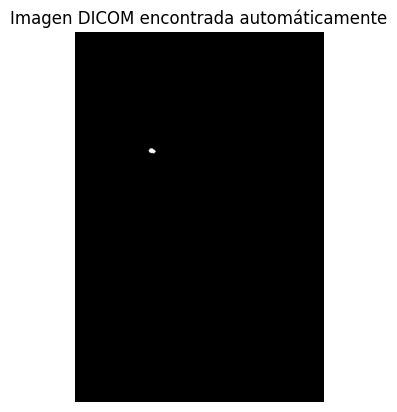


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00991_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.197679650210465644301111522573998527663/1.3.6.1.4.1.9590.100.1.2.115467132111304335901137916233667214569/1-2.dcm


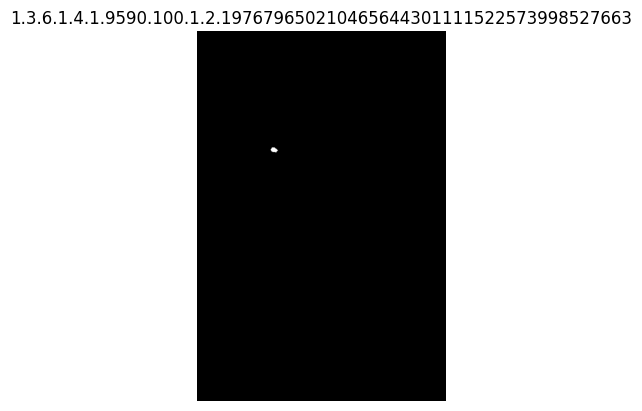


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00991_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.197679650210465644301111522573998527663/1.3.6.1.4.1.9590.100.1.2.115467132111304335901137916233667214569/1-1.dcm


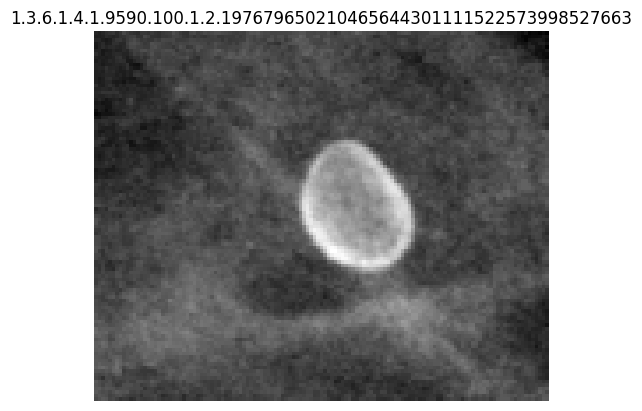


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Training_P_01844_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.34626139911214246732007187202875218197/1.3.6.1.4.1.9590.100.1.2.343415346312123544113551650783871288016/1-2.dcm


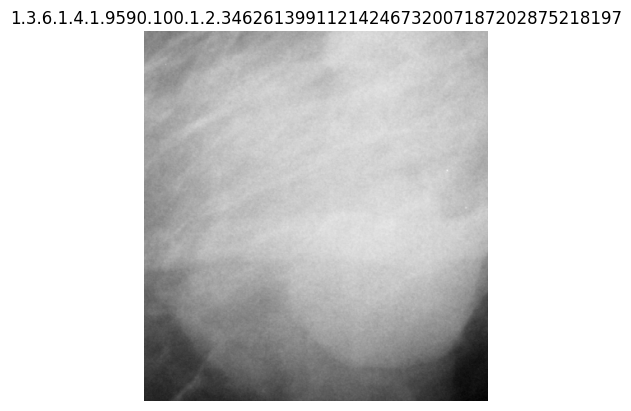


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Training_P_01844_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.34626139911214246732007187202875218197/1.3.6.1.4.1.9590.100.1.2.343415346312123544113551650783871288016/1-1.dcm


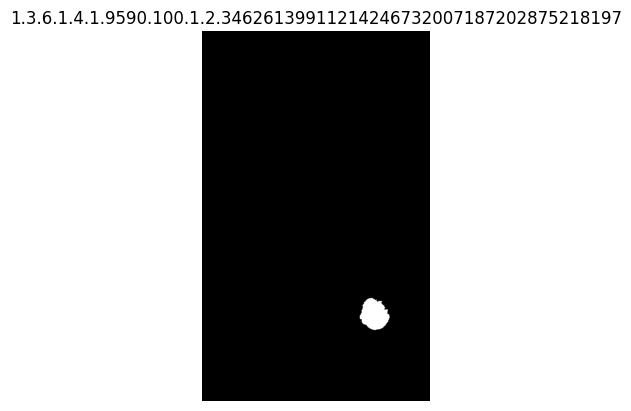


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Training_P_00703_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.332944262311909489515510672722545761997/1.3.6.1.4.1.9590.100.1.2.202675500012341890639589579582926153492/1-1.dcm


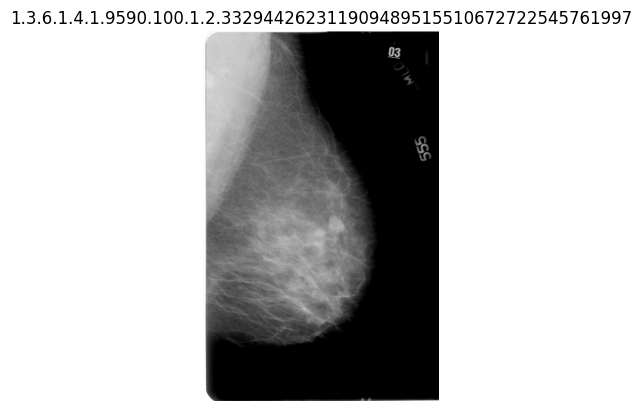


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Test_P_01566_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.234616849311382925724833783352722668501/1.3.6.1.4.1.9590.100.1.2.164750739813549290437512567251665770245/1-1.dcm


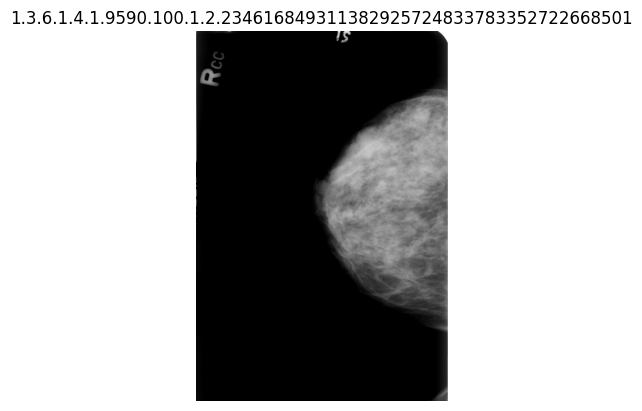


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00967_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.247404762613756277324507644551469768045/1.3.6.1.4.1.9590.100.1.2.83339404912524474831713499070934405979/1-2.dcm


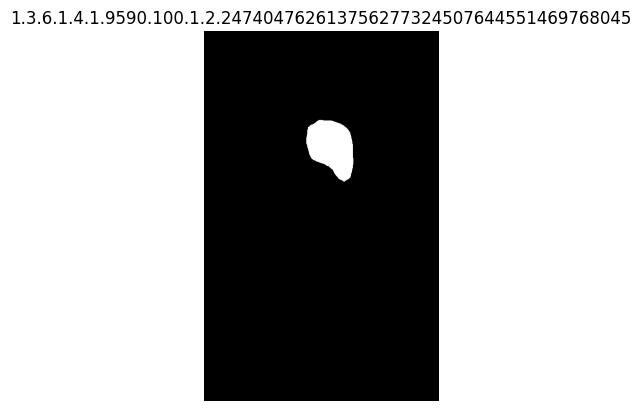


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00967_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.247404762613756277324507644551469768045/1.3.6.1.4.1.9590.100.1.2.83339404912524474831713499070934405979/1-1.dcm


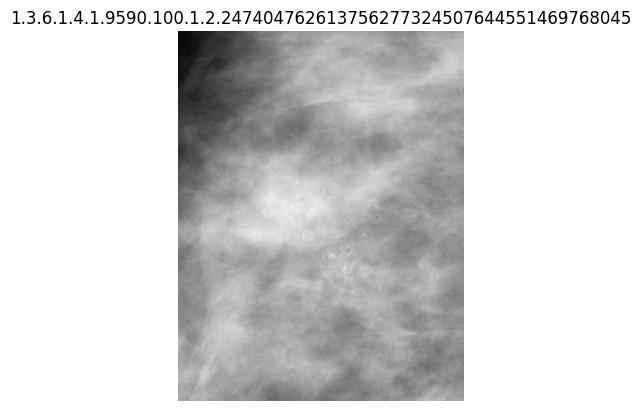


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_01885_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.411936919211703316006492415023219952613/1.3.6.1.4.1.9590.100.1.2.412805349511988982041074955902270862072/1-1.dcm


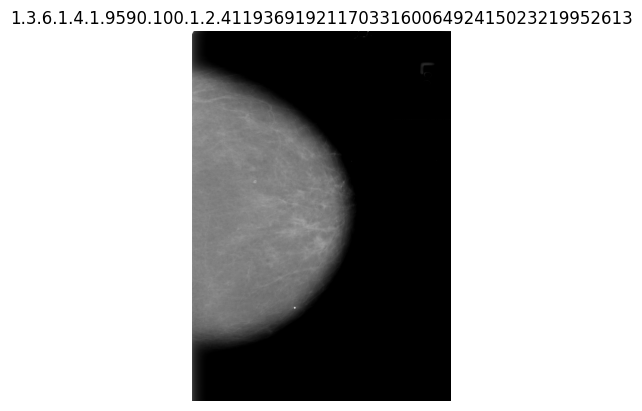


Mostrando: /Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_02393_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414450452112276708226385394091284430169/1.3.6.1.4.1.9590.100.1.2.284464123012025065005317272673765215147/1-2.dcm


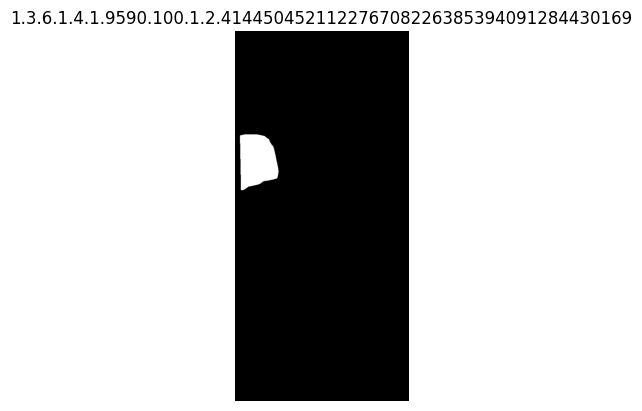

In [18]:
import os
import glob
import pydicom
import matplotlib.pyplot as plt

# Ruta base
base_path = '/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM'

# Buscar todos los archivos .dcm de forma recursiva
dcm_files = glob.glob(os.path.join(base_path, "**", "*.dcm"), recursive=True)

# Verificar y mostrar la primera imagen
if dcm_files:
    example_path = dcm_files[0]
    print("Archivo encontrado:", example_path)

    dicom = pydicom.dcmread(example_path)
    plt.imshow(dicom.pixel_array, cmap='gray')
    plt.title("Imagen DICOM encontrada autom√°ticamente")
    plt.axis('off')
    plt.show()
else:
    print("No se encontr√≥ ning√∫n archivo DICOM en el dataset")

# Mostrar las primeras 10 im√°genes del dataset
for path in dcm_files[:10]:
    print("\nMostrando:", path)
    dicom = pydicom.dcmread(path)
    plt.imshow(dicom.pixel_array, cmap='gray')
    plt.title(path.split("/")[-3])
    plt.axis('off')
    plt.show()

### Escalado de los datos con `StandardScaler`

Este paso aplica una transformaci√≥n de escalado a las variables predictoras (`X_train`, `X_val`, `X_test`) utilizando `StandardScaler`, una t√©cnica fundamental cuando se entrena un modelo SVM.

**Importancia:**
- El modelo SVM es muy sensible a las diferencias de escala entre variables.
- `StandardScaler` convierte cada feature a una distribuci√≥n con media 0 y desviaci√≥n est√°ndar 1.
- Esto evita que features con valores grandes (como `width` o `height`) dominen el modelo.

Se entrena el `scaler` solo con los datos de entrenamiento (`fit_transform`) y luego se aplica la misma transformaci√≥n a validaci√≥n y test (`transform`), garantizando un flujo limpio y sin fuga de informaci√≥n.


In [19]:
# Escalado de los datos antes de entrenar el modelo
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Entrenamiento del Modelo SVM

### Optimizaci√≥n de hiperpar√°metros del modelo SVM con GridSearchCV

En este bloque se realiza una b√∫squeda exhaustiva de la mejor combinaci√≥n de hiperpar√°metros del modelo SVM mediante `GridSearchCV`.

Se emplea validaci√≥n cruzada estratificada (`StratifiedKFold`) para garantizar que cada pliegue respete la proporci√≥n de clases, y se eval√∫a el rendimiento usando la m√©trica `f1_weighted`, adecuada para clasificaci√≥n multiclase desbalanceada.

El objetivo es seleccionar la combinaci√≥n √≥ptima de:

- `C`: penalizaci√≥n del margen
- `kernel`: tipo de n√∫cleo (lineal, RBF, polin√≥mico)
- `gamma`: par√°metro del kernel
- `class_weight`: balanceo autom√°tico entre clases

Al finalizar, se entrena el mejor modelo encontrado sobre los datos escalados.


In [20]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

# Validaci√≥n cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid de hiperpar√°metros
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

# B√∫squeda de mejor modelo
svc = SVC(probability=True)
grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

print(X_train_scaled,y_train)

grid.fit(X_train_scaled, y_train)

# Resultados
print("üìå Mejor combinaci√≥n encontrada:")
print(grid.best_params_)
print(f"F1 ponderado en validaci√≥n cruzada: {grid.best_score_:.4f}")

# Guardar mejor modelo
svm_model = grid.best_estimator_


[[ 1.09982582  0.15236014 -0.41657641 ... -0.17633592 -1.49367408
   0.24335329]
 [-0.35676666  0.03006303  1.52068321 ...  1.3715927   1.67697674
  -1.49418307]
 [ 0.35134946  0.15551388  0.6423873  ... -0.17633592 -0.43679047
   0.24335329]
 ...
 [ 1.52250327  1.21131383 -0.98898922 ... -0.17633592 -1.49367408
  -2.36295126]
 [-1.07499713 -1.02419807  1.38652396 ... -0.95030022 -0.43679047
   1.11212148]
 [-0.6151073  -0.04269504 -0.2019216  ...  0.59762839  0.62009314
  -0.62541489]] 0       1
1       2
2       1
3       1
4       1
       ..
2826    1
2827    1
2828    2
2829    1
2830    2
Name: pathology_label, Length: 2831, dtype: int64
Fitting 3 folds for each of 36 candidates, totalling 108 fits
üìå Mejor combinaci√≥n encontrada:
{'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
F1 ponderado en validaci√≥n cruzada: 0.7862


### B√∫squeda de hiperpar√°metros (`GridSearchCV`)
Este bloque de c√≥digo implementa una b√∫squeda exhaustiva sobre una rejilla de hiperpar√°metros del modelo `SVC` (Support Vector Classification), utilizando validaci√≥n cruzada estratificada con 3 particiones. Eval√∫a distintas combinaciones de `C`, `kernel`, `gamma` y `class_weight` para optimizar la m√©trica F1 ponderada, y selecciona autom√°ticamente el mejor clasificador.


In [21]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        1.422876      0.030032         0.119514        0.005319      0.1   
1        2.666636      0.013397         0.498364        0.005987      0.1   
2        1.967334      0.009880         0.167543        0.011257      0.1   
3        1.281958      0.020771         0.109434        0.001882      0.1   
4        2.639943      0.030441         0.459406        0.007339      0.1   
5        2.056335      0.025953         0.164977        0.012374      0.1   
6        1.481189      0.043315         0.115459        0.002345      0.1   
7        2.980160      0.076442         0.557616        0.024442      0.1   
8        2.276689      0.059547         0.214959        0.012080      0.1   
9        1.426912      0.024370         0.130060        0.020408      0.1   
10       3.120441      0.027747         0.519067        0.001993      0.1   
11       2.493744      0.024475         0.157129        0.004109      0.1   
12       2.032381      0.063661         0.130156        0.012050      1.0   
13       2.136724      0.059834         0.372246        0.004873      1.0   
14       1.982161      0.054633         0.143476        0.003377      1.0   
15       1.803175      0.015179         0.119251        0.007452      1.0   
16       1.997012      0.012062         0.384578        0.006497      1.0   
17       1.906064      0.035873         0.141058        0.006929      1.0   
18       1.807811      0.039275         0.131056        0.021343      1.0   
19       2.103136      0.016711         0.365237        0.014101      1.0   
20       2.030728      0.031047         0.134039        0.000821      1.0   
21       1.840354      0.023279         0.117343        0.006863      1.0   
22       2.044584      0.026653         0.367217        0.004583      1.0   
23       1.977183      0.024741         0.131576        0.001159      1.0   
24       4.626736      0.235404         0.122145        0.006274     10.0   
25       1.995229      0.037390         0.317962        0.013661     10.0   
26       3.521352      0.020604         0.119624        0.009604     10.0   
27       4.625230      0.167683         0.118888        0.002398     10.0   
28       2.100181      0.033277         0.305986        0.002797     10.0   
29       3.701981      0.038037         0.125529        0.012727     10.0   
30       4.142234      0.328391         0.079247        0.010669     10.0   
31       2.018879      0.044920         0.336496        0.003445     10.0   
32       3.148522      0.090317         0.076471        0.001352     10.0   
33       3.416893      0.105589         0.061927        0.003844     10.0   
34       1.574790      0.037438         0.189342        0.003128     10.0   
35       2.381163      0.052504         0.065606        0.003279     10.0   

   param_class_weight param_gamma param_kernel  \
0                None       scale       linear   
1                None       scale          rbf   
2                None       scale         poly   
3                None        auto       linear   
4                None        auto          rbf   
5                None        auto         poly   
6            balanced       scale       linear   
7            balanced       scale          rbf   
8            balanced       scale         poly   
9            balanced        auto       linear   
10           balanced        auto          rbf   
11           balanced        auto         poly   
12               None       scale       linear   
13               None       scale          rbf   
14               None       scale         poly   
15               None        auto       linear   
16               None        auto          rbf   
17               None        auto         poly   
18           balanced       scale       linear   
19           balanced       scale          rbf   
20           balanced       scale         poly   
21           balanced        auto       linear   
22  

### Evaluaci√≥n del Modelo


 Evaluaci√≥n sobre Entrenamiento (Train):



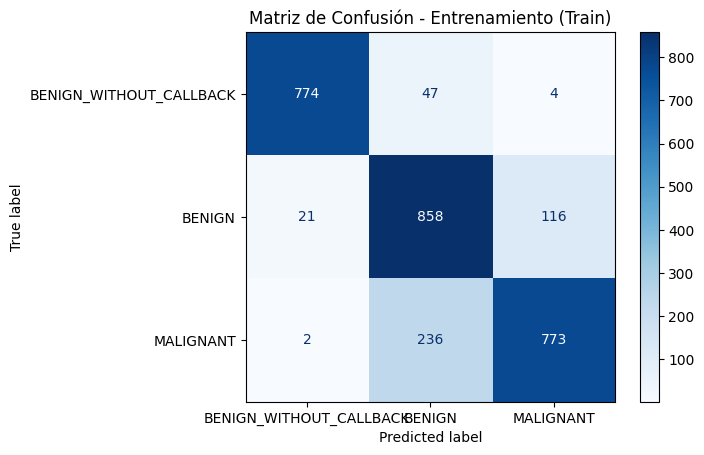

Reporte de Clasificaci√≥n:
                         precision    recall  f1-score   support

BENIGN_WITHOUT_CALLBACK       0.97      0.94      0.95       825
                 BENIGN       0.75      0.86      0.80       995
              MALIGNANT       0.87      0.76      0.81      1011

               accuracy                           0.85      2831
              macro avg       0.86      0.86      0.86      2831
           weighted avg       0.86      0.85      0.85      2831

Accuracy en Entrenamiento (Train): 0.8495

 Evaluaci√≥n sobre Validaci√≥n (Val):



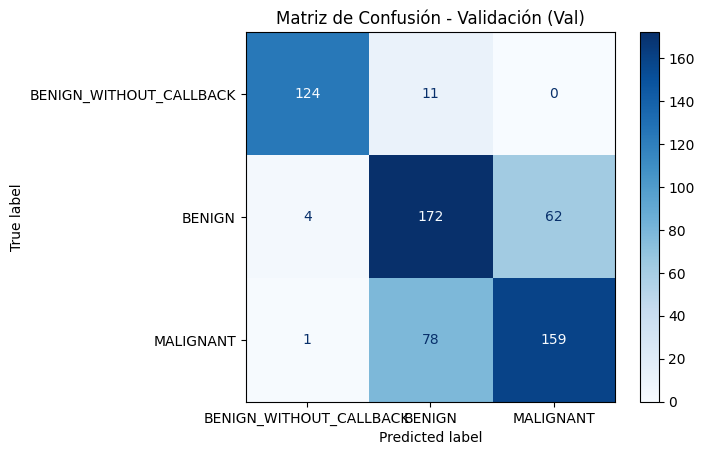

Reporte de Clasificaci√≥n:
                         precision    recall  f1-score   support

BENIGN_WITHOUT_CALLBACK       0.96      0.92      0.94       135
                 BENIGN       0.66      0.72      0.69       238
              MALIGNANT       0.72      0.67      0.69       238

               accuracy                           0.74       611
              macro avg       0.78      0.77      0.77       611
           weighted avg       0.75      0.74      0.75       611

Accuracy en Validaci√≥n (Val): 0.7447

 Evaluaci√≥n sobre Test:



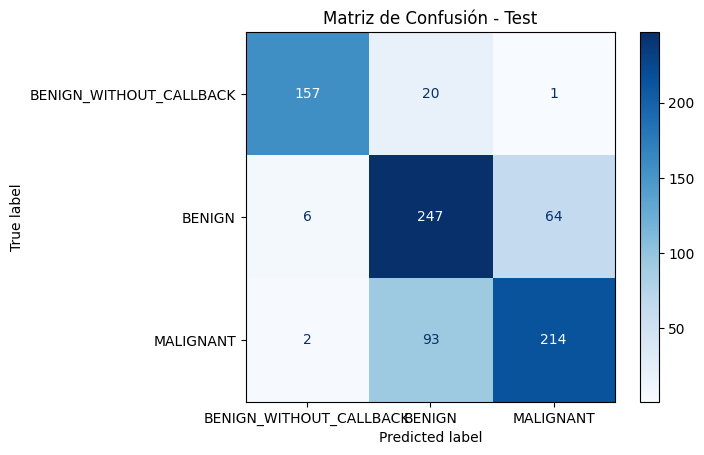

Reporte de Clasificaci√≥n:
                         precision    recall  f1-score   support

BENIGN_WITHOUT_CALLBACK       0.95      0.88      0.92       178
                 BENIGN       0.69      0.78      0.73       317
              MALIGNANT       0.77      0.69      0.73       309

               accuracy                           0.77       804
              macro avg       0.80      0.78      0.79       804
           weighted avg       0.78      0.77      0.77       804

Accuracy en Test: 0.7687


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Etiquetas originales seg√∫n el orden de codificaci√≥n
label_names = ['BENIGN_WITHOUT_CALLBACK', 'BENIGN', 'MALIGNANT']

# Diccionario con datos escalados para evaluar
eval_sets = {
    'Entrenamiento (Train)': (X_train_scaled, y_train),
    'Validaci√≥n (Val)': (X_val_scaled, y_val),
    'Test': (X_test_scaled, y_test)
}

# Evaluar modelo sobre cada conjunto
for nombre, (X_set, y_true) in eval_sets.items():
    print(f"\n Evaluaci√≥n sobre {nombre}:\n")

    y_pred = svm_model.predict(X_set)

    # Matriz de confusi√≥n
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusi√≥n - {nombre}")
    plt.grid(False)
    plt.show()

    # Reporte de clasificaci√≥n
    print("Reporte de Clasificaci√≥n:")
    print(classification_report(y_true, y_pred, target_names=label_names))

    # Accuracy simple
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy en {nombre}: {accuracy:.4f}")

| M√©trica       | Significado                                 | Qu√© representa                                               | Rango t√≠pico | Qu√© indica                        |
| ------------- | ------------------------------------------- | ------------------------------------------------------------ | ------------ | --------------------------------- |
| **Accuracy**  | Precisi√≥n global                            | % de predicciones correctas sobre el total                   | 0 a 1        | Qu√© tan bien clasifica en general |
| **Precision** | Precisi√≥n positiva                          | % de aciertos entre los que el modelo predijo como positivos | 0 a 1        | Minimiza falsos positivos (FP)    |
| **Recall**    | Sensibilidad o Tasa de verdaderos positivos | % de casos positivos correctamente detectados                | 0 a 1        | Minimiza falsos negativos (FN)    |
| **F1-score**  | Media arm√≥nica entre precision y recall     | Combina precisi√≥n y sensibilidad                             | 0 a 1        | Equilibrio entre FP y FN          |



In [17]:
import sys
!{sys.executable} -m pip install shap

zsh:1: no matches found: (Trabajo de Fin de Master)/notebooks/tfm_env/bin/python


### Explicabilidad por clase con SHAP (summary plots)

En este bloque se utiliza la t√©cnica SHAP (SHapley Additive exPlanations) con `KernelExplainer` para analizar c√≥mo influye cada caracter√≠stica en la predicci√≥n **por clase** del modelo SVM.

- Se usa la funci√≥n `predict_proba()` para obtener las probabilidades de cada clase.
- Se construye un explicador SHAP independiente para cada clase (`BENIGN_WITHOUT_CALLBACK`, `BENIGN`, `MALIGNANT`).
- El background se resume usando `KMeans` sobre los datos de entrenamiento escalados.
- Se genera un `summary_plot` por clase que muestra c√≥mo contribuyen las variables a aumentar o disminuir la probabilidad de pertenencia a esa clase.

Esto permite entender el modelo de forma **global** para cada clase, lo cual es especialmente √∫til en clasificaci√≥n multiclase con desequilibrios.



/Users/clubability/Documents/Maestria/TFM (Trabajo de Fin de Master)/notebooks/tfm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 SHAP para clase 0 ‚Üí BENIGN_WITHOUT_CALLBACK


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:07<00:00,  6.82it/s]


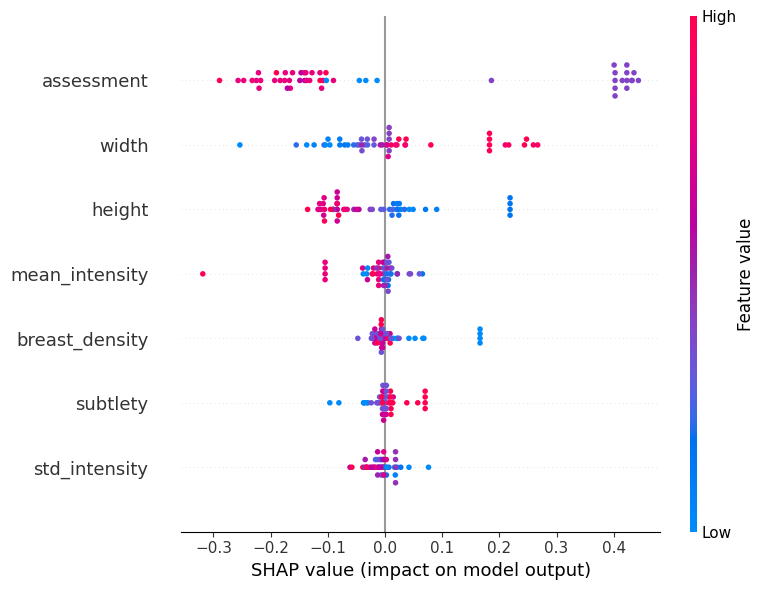


 SHAP para clase 1 ‚Üí BENIGN


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:06<00:00,  7.18it/s]


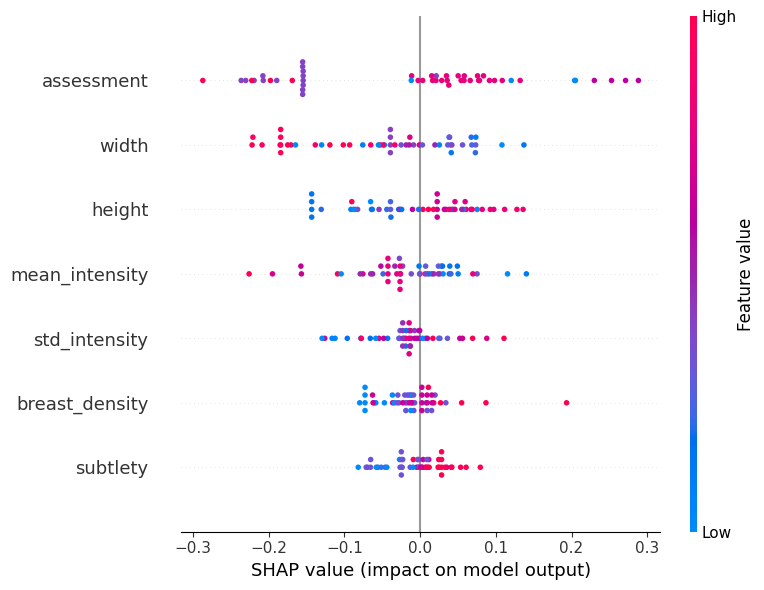


 SHAP para clase 2 ‚Üí MALIGNANT


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:07<00:00,  6.39it/s]


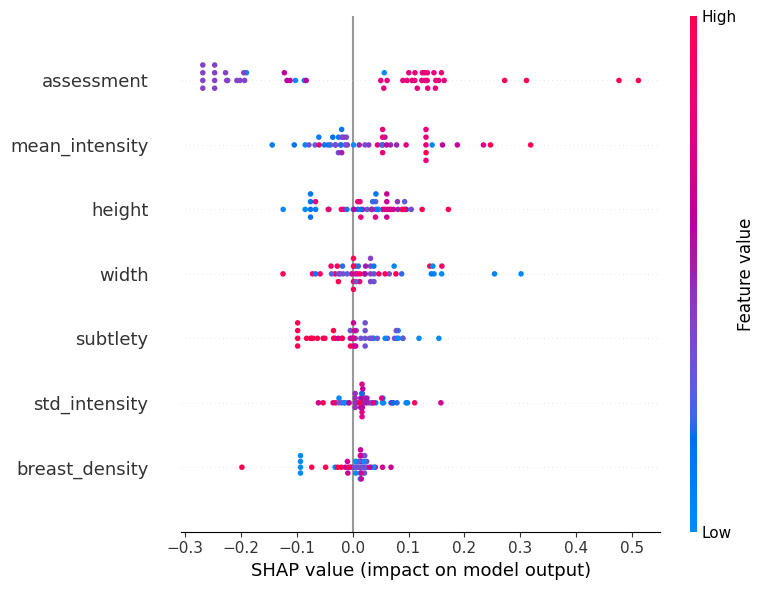

In [18]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Lista de features usados en el modelo
features_usar = [
    "mean_intensity", "std_intensity", "width", "height",
    "assessment", "breast_density", "subtlety"
]

# Convertimos X_sample a DataFrame con nombres
X_sample = X_val_scaled[:50]
X_sample_df = pd.DataFrame(X_sample, columns=features_usar)

# Background con KMeans (como resumen representativo del entrenamiento)
background = KMeans(n_clusters=10, random_state=42).fit(X_train_scaled).cluster_centers_

# Obtener probabilidades por clase
# predict_proba devuelve shape (n_samples, n_classes)
predict_proba = svm_model.predict_proba

# Etiquetas de clase seg√∫n orden de codificaci√≥n
clases = ['BENIGN_WITHOUT_CALLBACK', 'BENIGN', 'MALIGNANT']

# Repetimos para cada clase
for i, clase in enumerate(clases):
    print(f"\n SHAP para clase {i} ‚Üí {clase}")

    # Funci√≥n que devuelve solo la probabilidad de la clase i
    def prob_clase_i(X):
        return predict_proba(X)[:, i]

    # Crear un nuevo explicador SHAP solo para esa clase
    explainer_i = shap.KernelExplainer(prob_clase_i, background)

    # Calcular valores SHAP solo para esa clase
    shap_values_i = explainer_i.shap_values(X_sample)

    # Visualizar el resumen para esa clase
    shap.summary_plot(shap_values_i, X_sample_df, feature_names=features_usar, plot_size=(8, 6))



### Interpretaci√≥n individual con gr√°fico tipo Waterfall (SHAP)

Este gr√°fico muestra c√≥mo cada una de las 7 caracter√≠sticas contribuye a la predicci√≥n final del modelo SVM para una observaci√≥n espec√≠fica del conjunto de test.

- `E[f(X)]` representa el valor promedio de predicci√≥n del modelo para la clase seleccionada (en este caso, clase `i = 2` ‚Üí *MALIGNANT*).
- `f(x)` es la predicci√≥n final para la muestra analizada.
- Cada barra muestra cu√°nto influye una caracter√≠stica espec√≠fica para acercarse o alejarse del valor promedio:
  - üî¥ Barras rojas: contribuyen **positivamente** a aumentar la probabilidad de la clase.
  - üîµ Barras azules: contribuyen **negativamente**, reduciendo la probabilidad.
  
Este tipo de explicabilidad es especialmente √∫til en contextos cl√≠nicos, donde es necesario justificar por qu√© el modelo ha clasificado un caso como *maligno* o *benigno* seg√∫n sus valores individuales.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  5.69it/s]


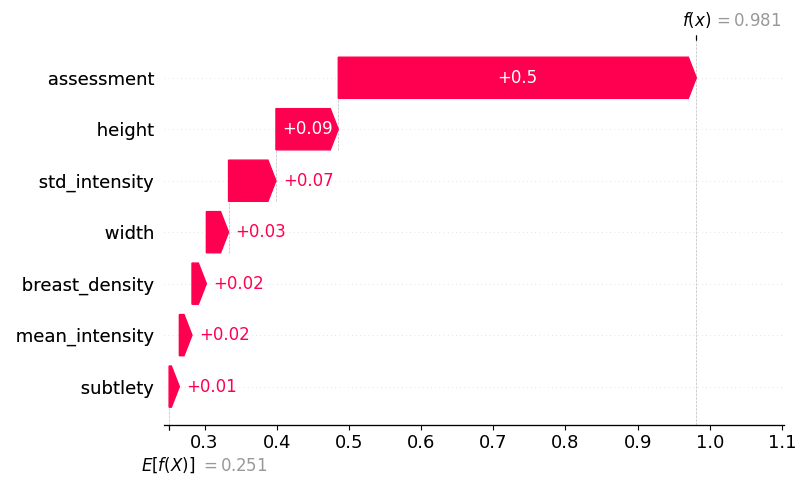

In [19]:
import shap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

# Lista de features usados
features_usar = [
    "mean_intensity", "std_intensity", "width", "height",
    "assessment", "breast_density", "subtlety"
]

# Background para SHAP (resumen del entrenamiento)
background = KMeans(n_clusters=10, random_state=42).fit(X_train_scaled).cluster_centers_

# Convertir X_test_scaled en DataFrame
X_test_df = pd.DataFrame(X_test_scaled, columns=features_usar)

# Seleccionamos una observaci√≥n espec√≠fica
i_obs = 5  # puedes cambiar este √≠ndice a cualquier muestra
x_explicar = X_test_scaled[i_obs:i_obs+1]

# Elegir clase a explicar (0, 1 o 2)
i_clase = 2  # por ejemplo: 2 = MALIGNANT

# Crear funci√≥n que devuelve solo probabilidad de esa clase
def predict_clase_i(X):
    return svm_model.predict_proba(X)[:, i_clase]

# Crear el explicador para esa clase
explainer = shap.KernelExplainer(predict_clase_i, background)

# Obtener valores SHAP para esa muestra
shap_values = explainer.shap_values(x_explicar)

# Visualizar con waterfall
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],         # como es una sola muestra
    X_test_df.iloc[i_obs],  # los valores de entrada originales
    feature_names=features_usar
)

### Evaluaci√≥n del modelo SVM con curvas ROC por clase

En esta secci√≥n se calcula y visualiza la curva ROC (Receiver Operating Characteristic) para cada una de las tres clases objetivo del modelo SVM:  
`BENIGN_WITHOUT_CALLBACK`, `BENIGN` y `MALIGNANT`.

Para ello:

- Se binarizan las etiquetas (`one-vs-rest`) mediante `label_binarize`.
- Se utiliza la salida cruda del modelo (`decision_function`) como score.
- Se calcula el **√Årea Bajo la Curva (AUC)** para cada clase por separado.
- Se genera la curva ROC correspondiente a cada clase junto con una l√≠nea base aleatoria.
- Se calcula tambi√©n el **AUC macro promedio**, que eval√∫a el rendimiento general del modelo multiclase sin ponderaci√≥n.

Este an√°lisis permite evaluar la capacidad del modelo para distinguir entre clases m√°s all√° de la simple precisi√≥n, especialmente √∫til en contextos m√©dicos donde los falsos positivos y negativos tienen distinto impacto.


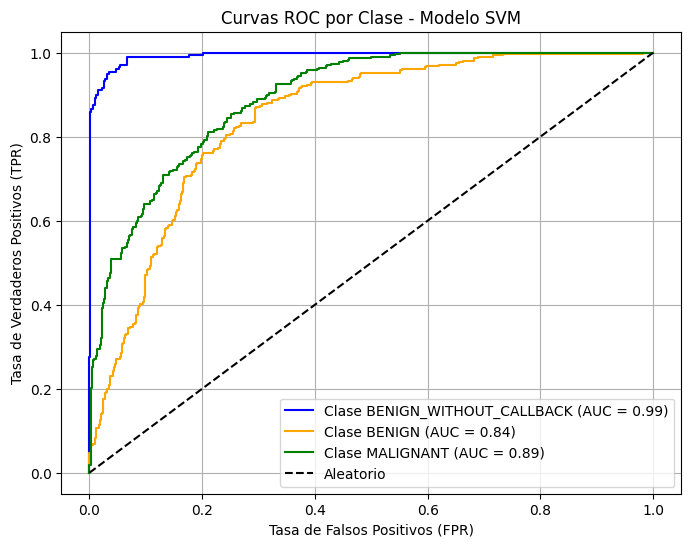

AUC macro promedio: 0.9105


In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Etiquetas de clase en orden de codificaci√≥n
clases = ['BENIGN_WITHOUT_CALLBACK', 'BENIGN', 'MALIGNANT']

# Binarizar las etiquetas para one-vs-rest
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Obtener scores del modelo (logits)
y_score = svm_model.decision_function(X_test_scaled)

# Calcular curvas ROC y AUC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro promedio
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Visualizaci√≥n
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"Clase {clases[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.title("Curvas ROC por Clase - Modelo SVM")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# AUC macro
print(f"AUC macro promedio: {macro_auc:.4f}")



### Guardado del Modelo SVM Optimizado y del GridSearchCV Completo

En esta secci√≥n se guardan dos versiones del modelo entrenado:

1. **Modelo final (`svm_model_final.pkl`)**  
   Contiene √∫nicamente el mejor modelo entrenado (`SVC`) con los hiperpar√°metros √≥ptimos.  
   Es ideal para:
   - Realizar predicciones r√°pidamente
   - Aplicar interpretabilidad (SHAP, curvas ROC, etc.)
   - Usar en producci√≥n

2. **GridSearchCV completo (`svm_grid.pkl`)**  
   Contiene todo el objeto de b√∫squeda, incluyendo:
   - Todas las combinaciones de hiperpar√°metros evaluadas
   - Resultados de validaci√≥n cruzada (`cv_results_`)
   - Acceso al mejor modelo (`best_estimator_`)

Este enfoque permite mantener un modelo liviano para uso pr√°ctico, sin perder acceso a los metadatos del proceso de optimizaci√≥n, lo cual es muy √∫til para documentaci√≥n o mejora futura.




In [23]:
import os
import joblib

# Crear carpeta si no existe
ruta_directorio_modelo = '/Users/clubability/Documents/Dataset_TFM/modelos'
os.makedirs(ruta_directorio_modelo, exist_ok=True)

# Ruta 1: modelo final optimizado
ruta_modelo_final = os.path.join(ruta_directorio_modelo, 'svm_model_final.pkl')
joblib.dump(svm_model, ruta_modelo_final)  # aqu√≠ guardas best_estimator_

# Ruta 2: GridSearchCV completo
ruta_grid = os.path.join(ruta_directorio_modelo, 'svm_grid.pkl')
joblib.dump(grid, ruta_grid)  # aqu√≠ guardas el objeto GridSearchCV completo

print(f"- Modelo final guardado en: {ruta_modelo_final}")
print(f"- GridSearchCV completo guardado en: {ruta_grid}")

- Modelo final guardado en: /Users/clubability/Documents/Dataset_TFM/modelos/svm_model_final.pkl
- GridSearchCV completo guardado en: /Users/clubability/Documents/Dataset_TFM/modelos/svm_grid.pkl


In [24]:
# Cargar solo el modelo listo para predicci√≥n
modelo_final = joblib.load(ruta_modelo_final)

# Cargar el grid completo para ver resultados
grid_completo = joblib.load(ruta_grid)
# Mostrar los mejores hiperpar√°metros encontrados por GridSearchCV
print("Mejores hiperpar√°metros:", grid_completo.best_params_)

Mejores hiperpar√°metros: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
